# Compute Bertscore

In [16]:
from evaluate import load
import json

result_path = "../json_files/bert_score_results.json"

In [ ]:
core_claim_json_path = "..\json_files\preliminary_experiments\core_claims_eval.json"

with open(core_claim_json_path, 'r', encoding="utf-8") as j:
    core_claims_eval = json.loads(j.read())

In [ ]:
#helper functions for reformating and extracting the dict
def extract_core_claim_dict(article, reformat=True):
    core_claims = {}
    for key, value in article.items():
        if "core_claims" in key:
            core_claims[key] = value
    if (reformat):
        return reformat_core_claim_dict(core_claim_dict=core_claims)
    return core_claims


def reformat_core_claim_dict(core_claim_dict):
    core_claim_comparison = {}
    core_claim_comparison["core_claim_pairs"] = []
    for key_p, value_p in core_claim_dict.items():
        for key_r, value_r in core_claim_dict.items():
            if key_p == key_r:
                continue
            p_r_dict = {}
            p_r_dict['p'] = key_p
            p_r_dict['r'] = key_r
            p_r_dict['claim_pairs'] = []
            for claim_p in value_p:
                claim_pair = {
                    "claims_prediction" : [claim_p] * len(value_r),
                    "claims_reference" : value_r
                }
                p_r_dict['claim_pairs'].append(claim_pair)
            core_claim_comparison['core_claim_pairs'].append(p_r_dict)
    return core_claim_comparison

from evaluate import load
bertscore = load("bertscore")

def get_result_dict(article):
    results_core_claim_comparison = extract_core_claim_dict(article)
    for pair in results_core_claim_comparison['core_claim_pairs']:
        
        pair['scores'] = {}
        
        for i, claim_pair in enumerate(pair['claim_pairs']):
            results = bertscore.compute(predictions=claim_pair['claims_prediction'], references=claim_pair['claims_reference'], model_type="distilbert-base-uncased")
            del results['hashcode']
            pair['scores'][f'claim_{i+1}'] = results
        del pair['claim_pairs']
    return results_core_claim_comparison

In [ ]:
results = {}
results['articles'] = []
for article in core_claims_eval['articles']:
    article_dict = {}
    article_dict['article_title']= article['article_title']
    article_dict['results'] = get_result_dict(article)
    results['articles'].append(article_dict)

In [ ]:
#run only if changes are made to the code above
with open (result_path, "w") as f:
    json.dump(results, f)

# Process and display Results

In [17]:
import json
with open(result_path, 'r', encoding="utf-8") as j:
    results = json.loads(j.read())

In [ ]:
# import numpy as np
# for claim, scores in test_example_claims.items():
#     for metric, values in scores.items():
#         scores[f"{metric}"] = np.average(values)

# print (test_example_claims)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = results

#transform the data into a new dict containing averages and excluding duplicate p-r pairs
pr_pairs = {}
for article in data['articles']:
    for claim_pair in article['results']['core_claim_pairs']:
        pr_pair = frozenset({claim_pair['p'], claim_pair['r']})
        if pr_pair not in pr_pairs:
            pr_pairs[pr_pair] = {'claims': []}
        for claim, metrics in claim_pair['scores'].items():
            avg_precision = sum(metrics['precision']) / len(metrics['precision'])
            avg_recall = sum(metrics['recall']) / len(metrics['recall'])
            avg_f1 = sum(metrics['f1']) / len(metrics['f1'])
            pr_pairs[pr_pair]['claims'].append({
                'Claim': claim,
                'Precision': avg_precision,
                'Recall': avg_recall,
                'F1': avg_f1
            })

rows = []
for pr_pair, details in pr_pairs.items():
    for claim_details in details['claims']:
        pr_str = ', '.join(pr_pair)
        rows.append({
            'Claim': claim_details['Claim'],
            'Metric': 'Precision',
            'Value': claim_details['Precision'], #add each metric into their own row
            'P-R Pair': pr_str,
            'Highlight': '_llama' in pr_str or '_gemini' in pr_str #add a boolean distinction between pairs containing a LLM and ones that don't
        })
        rows.append({
            'Claim': claim_details['Claim'],
            'Metric': 'Recall',
            'Value': claim_details['Recall'],
            'P-R Pair': pr_str,
            'Highlight': '_llama' in pr_str or '_gemini' in pr_str
        })
        rows.append({
            'Claim': claim_details['Claim'],
            'Metric': 'F1',
            'Value': claim_details['F1'],
            'P-R Pair': pr_str,
            'Highlight': '_llama' in pr_str or '_gemini' in pr_str
        })

df = pd.DataFrame(rows)
df



,Claim,Metric,Value,P-R Pair,Highlight
0,claim_1,Precision,0.791067,"core_claims_gemini_naive, core_claims_llama",True
1,claim_1,Recall,0.787880,"core_claims_gemini_naive, core_claims_llama",True
2,claim_1,F1,0.789348,"core_claims_gemini_naive, core_claims_llama",True
3,claim_2,Precision,0.780099,"core_claims_gemini_naive, core_claims_llama",True
4,claim_2,Recall,0.802476,"core_claims_gemini_naive, core_claims_llama",True
...,...,...,...,...,...
1420,claim_4,Recall,0.695392,"core_claims_reader_3, core_claims_reader_4",False
1421,claim_4,F1,0.698061,"core_claims_reader_3, core_claims_reader_4",False
1422,claim_5,Precision,0.670614,"core_claims_reader_3, core_claims_reader_4",False
1423,claim_5,Recall,0.736838,"core_claims_reader_3, core_claims_reader_4",False


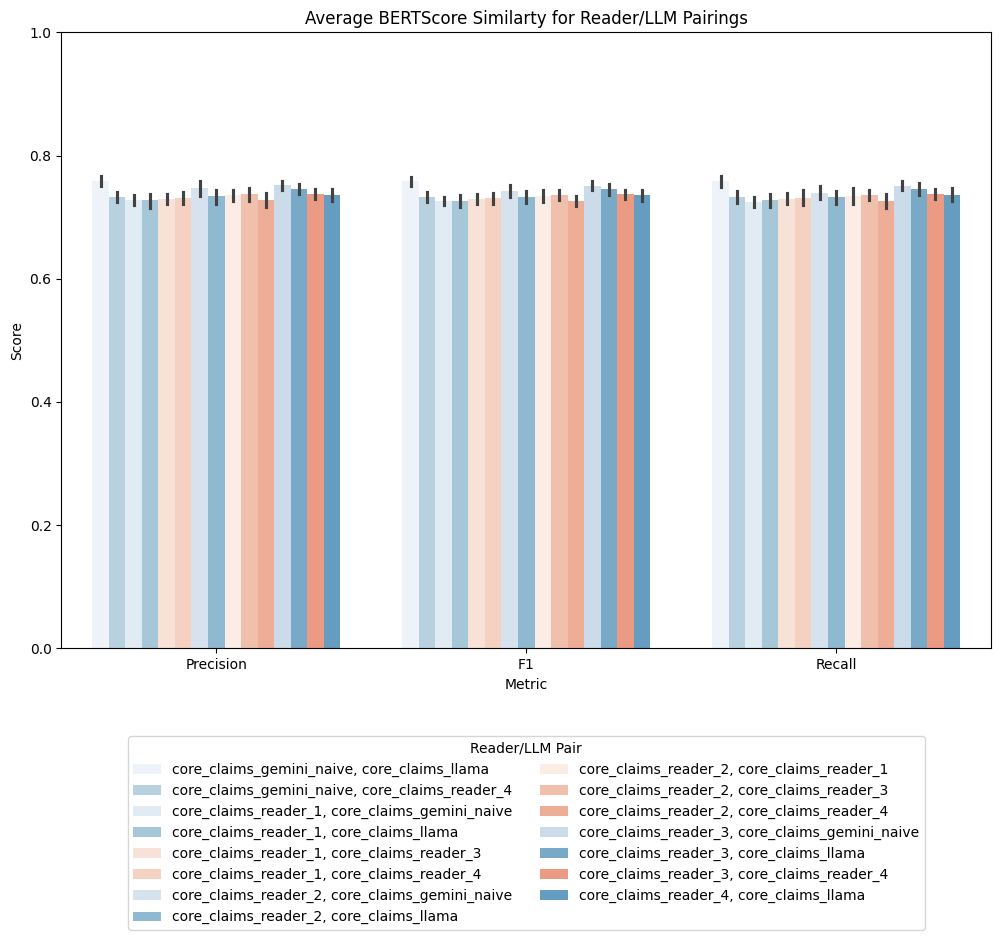

In [19]:
#assigning two custom palette to highlight specific pairs
palette = {}
base_palette = sns.color_palette("Reds", df['P-R Pair'].nunique())
highlight_palette = sns.color_palette("Blues", df['P-R Pair'].nunique())

for pr in df['P-R Pair'].unique():
    if any(x in pr for x in ['_llama', '_gemini']):
        palette[pr] = highlight_palette.pop(0)
    else:
        palette[pr] = base_palette.pop(0)

#plot with distinct colors for highlighted pairs
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Metric', y='Value', hue='P-R Pair', data=df.sort_values(by=['P-R Pair']), palette=palette)
plt.title('Average BERTScore Similarty for Reader/LLM Pairings')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Reader/LLM Pair')
sns.move_legend(ax, "center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.show()


In [21]:
metric_averages = df.groupby(['P-R Pair', 'Metric'])['Value'].describe().sort_index()
metric_averages.sort_index(axis='index', ascending=False)

count      mean  \
P-R Pair                                       Metric                       
core_claims_reader_4, core_claims_llama        Recall      30.0  0.736077   
                                               Precision   30.0  0.736077   
                                               F1          30.0  0.735537   
core_claims_reader_3, core_claims_reader_4     Recall      30.0  0.737370   
                                               Precision   30.0  0.737370   
                                               F1          30.0  0.737029   
core_claims_reader_3, core_claims_llama        Recall      30.0  0.745369   
                                               Precision   30.0  0.745369   
                                               F1          30.0  0.745133   
core_claims_reader_3, core_claims_gemini_naive Recall      36.0  0.751030   
                                               Precision   36.0  0.751833   
                                               F1          36.0  0.751228   
core_claims_reader_2, core_claims_reader_4     Recall      29.0  0.726890   
                                               Precision   29.0  0.727982   
                                               F1          29.0  0.726496   
core_claims_reader_2, core_claims_reader_3     Recall      29.0  0.735990   
                                               Precision   29.0  0.737195   
                                               F1          29.0  0.735992   
core_claims_reader_2, core_claims_reader_1     Recall      29.0  0.734462   
                                               Precision   29.0  0.735101   
                                               F1          29.0  0.733946   
core_claims_reader_2, core_claims_llama        Recall      29.0  0.732099   
                                               Precision   29.0  0.733617   
                                               F1          29.0  0.732162   
core_claims_reader_2, core_claims_gemini_naive Recall      35.0  0.739641   
                                               Precision   35.0  0.746624   
                                               F1          35.0  0.742443   
core_claims_reader_1, core_claims_reader_4     Recall      30.0  0.731155   
                                               Precision   30.0  0.731155   
                                               F1          30.0  0.730279   
core_claims_reader_1, core_claims_reader_3     Recall      30.0  0.730137   
                                               Precision   30.0  0.730137   
                                               F1          30.0  0.729631   
core_claims_reader_1, core_claims_llama        Recall      30.0  0.727175   
                                               Precision   30.0  0.727175   
                                               F1          30.0  0.726600   
core_claims_reader_1, core_claims_gemini_naive Recall      36.0  0.725120   
                                               Precision   36.0  0.727500   
                                               F1          36.0  0.725741   
core_claims_gemini_naive, core_claims_reader_4 Recall      36.0  0.732232   
                                               Precision   36.0  0.733080   
                                               F1          36.0  0.732267   
core_claims_gemini_naive, core_claims_llama    Recall      36.0  0.757961   
                                               Precision   36.0  0.758686   
                                               F1          36.0  0.758054   

                                                               std       min  \
P-R Pair                                       Metric                          
core_claims_reader_4, core_claims_llama        Recall     0.031158  0.680036   
                                               Precision  0.029089  0.661916   
                                               F1         0.026332  0.693284   
core_claims_reader_3, core_claims_read

In [ ]:
from scipy import stats
import numpy as np

# Calculate metric averages
metric_averages = df.groupby(['Metric', 'P-R Pair'])['Value'].mean().reset_index()

# Apply z-score transformation
metric_averages['Z-Score'] = metric_averages.groupby(['Metric'])['Value'].transform(lambda x: stats.zscore(x))

# Identify outliers
outliers = metric_averages[metric_averages['Z-Score'] < -1.1]

print("Outliers based on Z-Score:")
print(outliers)


Outliers based on Z-Score:
    Metric                                        P-R Pair    Value   Z-Score
32  Recall  core_claims_reader_1, core_claims_gemini_naive  0.72512 -1.247312


Further Descriptive Statistics

In [33]:
metric_averages.groupby('Metric')['Value'].describe() #averages of the groups

,count,mean,std,min,25%,50%,75%,max
Metric,,,,,,,,
F1,15.0,0.736169,0.009389,0.725741,0.729955,0.733946,0.739736,0.758054
Precision,15.0,0.737260,0.009384,0.727175,0.730646,0.735101,0.741370,0.758686
Recall,15.0,0.736181,0.009179,0.725120,0.730646,0.734462,0.738506,0.757961


In [ ]:
total_averages = df.groupby('Metric')['Value'].describe() #total description
print(total_averages)

           count      mean       std       min       25%       50%       75%  \
Metric                                                                         
F1         475.0  0.736555  0.026002  0.662515  0.717924  0.735144  0.755557   
Precision  475.0  0.737669  0.029115  0.635502  0.719593  0.738554  0.758105   
Recall     475.0  0.736522  0.030690  0.645202  0.715940  0.736347  0.756286   

                max  
Metric               
F1         0.802850  
Precision  0.804226  
Recall     0.836201  


In [24]:
minimum_values = df.groupby(['P-R Pair', 'Metric'])['Value'].describe()
minimum_values

count      mean  \
P-R Pair                                       Metric                       
core_claims_gemini_naive, core_claims_llama    F1          36.0  0.758054   
                                               Precision   36.0  0.758686   
                                               Recall      36.0  0.757961   
core_claims_gemini_naive, core_claims_reader_4 F1          36.0  0.732267   
                                               Precision   36.0  0.733080   
                                               Recall      36.0  0.732232   
core_claims_reader_1, core_claims_gemini_naive F1          36.0  0.725741   
                                               Precision   36.0  0.727500   
                                               Recall      36.0  0.725120   
core_claims_reader_1, core_claims_llama        F1          30.0  0.726600   
                                               Precision   30.0  0.727175   
                                               Recall      30.0  0.727175   
core_claims_reader_1, core_claims_reader_3     F1          30.0  0.729631   
                                               Precision   30.0  0.730137   
                                               Recall      30.0  0.730137   
core_claims_reader_1, core_claims_reader_4     F1          30.0  0.730279   
                                               Precision   30.0  0.731155   
                                               Recall      30.0  0.731155   
core_claims_reader_2, core_claims_gemini_naive F1          35.0  0.742443   
                                               Precision   35.0  0.746624   
                                               Recall      35.0  0.739641   
core_claims_reader_2, core_claims_llama        F1          29.0  0.732162   
                                               Precision   29.0  0.733617   
                                               Recall      29.0  0.732099   
core_claims_reader_2, core_claims_reader_1     F1          29.0  0.733946   
                                               Precision   29.0  0.735101   
                                               Recall      29.0  0.734462   
core_claims_reader_2, core_claims_reader_3     F1          29.0  0.735992   
                                               Precision   29.0  0.737195   
                                               Recall      29.0  0.735990   
core_claims_reader_2, core_claims_reader_4     F1          29.0  0.726496   
                                               Precision   29.0  0.727982   
                                               Recall      29.0  0.726890   
core_claims_reader_3, core_claims_gemini_naive F1          36.0  0.751228   
                                               Precision   36.0  0.751833   
                                               Recall      36.0  0.751030   
core_claims_reader_3, core_claims_llama        F1          30.0  0.745133   
                                               Precision   30.0  0.745369   
                                               Recall      30.0  0.745369   
core_claims_reader_3, core_claims_reader_4     F1          30.0  0.737029   
                                               Precision   30.0  0.737370   
                                               Recall      30.0  0.737370   
core_claims_reader_4, core_claims_llama        F1          30.0  0.735537   
                                               Precision   30.0  0.736077   
                                               Recall      30.0  0.736077   

                                                               std       min  \
P-R Pair                                       Metric                          
core_claims_gemini_naive, core_claims_llama    F1         0.023286  0.708579   
                                               Precision  0.022568  0.697367   
                                               Recall     0.027668  0.695309   
core_claims_gemini_naive, core_claims_

In [ ]:
maximum_values = df.groupby(['P-R Pair', 'Metric'])['Value'].max()
maximum_values

In [ ]:
std = df.groupby(['P-R Pair', 'Metric'])['Value'].std()
std